In [16]:
# @title Stage 1: Corpus Preparation & Structural Segmentation
# This cell prepares the structured text file for the LLM by parsing the source
# XML and applying the segmentation defined in the structure.txt file.

import sys
import os
import json
import csv
import shutil
from collections import OrderedDict
from datetime import datetime
from pathlib import Path
# Import refactored helper functions
sys.path.append('../') 
from src.corpus_parser import load_and_parse_xml, parse_citation, get_book_number_map
from src.config import *

XML_FILENAME = f"{BIBLE_NAME}_bible.xml"
STRUCTURE_FILENAME = f"{STRUCTURE_NAME}_structure.txt"
OUTPUT_FILENAME = f"{STRUCTURE_NAME}_{BIBLE_NAME}_structured.json"

def process_bible_text(xml_file_path, structure_file_path=None, output_file_path=None):
    print(f"{datetime.now().strftime('%d.%m.%Y/%H:%M:%S')} --- Stage 1: Starting Corpus Preparation ---")
    bible_data, book_abbr_map, translation_name = load_and_parse_xml(xml_file_path)
    if bible_data is None: return
    narrative_units, structure_full, structure_short = [], "", ""
    book_map = get_book_number_map()
    if structure_file_path:
        print(f"Processing with structure file: {structure_file_path}")
        try:
            with open(structure_file_path, 'r', encoding='utf-8', errors='ignore') as f: lines = f.readlines()
            non_comment_lines = [line.strip() for line in lines if line.strip() and not line.strip().startswith('#')]
            if not non_comment_lines or (len(non_comment_lines) == 1 and non_comment_lines[0].upper() == "CHAPTER"):
                print("Structure file is empty or contains only 'CHAPTER'. Defaulting to chapter segmentation.")
                structure_short = "chapters"; structure_file_path = None
            else:
                structure_full = lines[0].strip()
                for line in lines:
                    if line.strip().startswith("# Short:"):
                        structure_short = line.strip()[len("# Short:"):].strip(); break
                csv_reader = csv.reader(lines, delimiter=',', quotechar='"')
                for parts in csv_reader:
                    if not parts or parts[0].strip().startswith('#'): continue
                    if len(parts) != 3: print(f"Warning: Skipping malformed line: {','.join(parts)}"); continue
                    unit_id, title, citation_str = [p.strip() for p in parts]
                    try: parsed_ranges = parse_citation(citation_str)
                    except ValueError as e: print(f"ERROR processing citation for unit '{unit_id}': {e}. Skipping."); continue
                    text_segments = []
                    for book_abbr, start_ch, start_v, end_ch, end_v in parsed_ranges:
                        book_num = book_map.get(book_abbr.upper())
                        if book_num is None or book_num not in bible_data: print(f"Warning: Book '{book_abbr}' not found for unit '{unit_id}'. Skipping."); continue
                        book_content = bible_data[book_num]
                        for c_num in range(start_ch, end_ch + 1):
                            if c_num not in book_content: continue
                            v_start = start_v if c_num == start_ch else 1
                            v_end = end_v if c_num == end_ch else max(book_content[c_num].keys())
                            for v_num in sorted(book_content[c_num].keys()):
                                 if v_start <= v_num <= v_end: text_segments.append(book_content[c_num][v_num])
                    full_text = " ".join(text_segments)
                    if not full_text.strip(): print(f"Warning: No text for unit '{unit_id}'. Skipping."); continue
                    num_verses = len(text_segments) # Dynamically count the verses
                    narrative_units.append(OrderedDict([
                        ("unit_id", unit_id),
                        ("title", title),
                        ("range", citation_str),
                        ("num_verses", num_verses), # Add the verse count here
                        ("full_text", full_text.strip())
                    ]))
        except Exception as e: print(f"ERROR processing structure file: {e}"); return
    if structure_file_path is None:
        print("Proceeding with default chapter-based segmentation.")
        book_num = get_book_number_map().get("RE") or next(iter(bible_data), None)
        if book_num is None or book_num not in bible_data: print("ERROR: Revelation content not found."); return
        book_content = bible_data[book_num]; book_abbr = book_abbr_map.get(book_num, f"BOOK_{book_num}"); structure_short = "chapters"
        for chap_num, verses in sorted(book_content.items()):
            if not verses: continue
            full_text = " ".join(verses[v_num] for v_num in sorted(verses.keys()))
            narrative_units.append(OrderedDict([("unit_id", f"chapter_{chap_num:02d}"), ("title", f"Chapter {chap_num}"), ("range", f"{book_abbr} {chap_num}"), ("full_text", full_text.strip())]))
    if not narrative_units: print("\nWARNING: No narrative units generated."); return
    output_data = OrderedDict([("translation", translation_name), ("structure_full", structure_full), ("structure_short", structure_short), ("narrative_units", narrative_units)])
    try:
        os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
        with open(output_file_path, 'w', encoding='utf-8') as f_out: json.dump(output_data, f_out, indent=2, ensure_ascii=False)
        print(f"\n✅ Stage 1 complete. Output saved to '{output_file_path}'")
    except Exception as e: print(f"ERROR writing output file: {e}")

def run_stage_one_interactive():
    xml_file_path_input = Path(PATH_INPUT) / XML_FILENAME
    if not os.path.exists(xml_file_path_input):
        print(f"❌ ERROR: XML file '{XML_FILENAME}' not found.")
        print(f"Please place the file in the '{os.path.abspath(PATH_INPUT)}' directory and run this cell again.")
        return
    else:
        print(f"✅ Found XML file: '{xml_file_path_input}'")

    struct_file_path_input = Path(PATH_INPUT) / STRUCTURE_FILENAME
    use_structure_file = True
    if not os.path.exists(struct_file_path_input):
        print(f"\nℹ️  Structure file '{STRUCTURE_FILENAME}' not found in '{os.path.abspath(PATH_INPUT)}'.")
        print("Proceeding with default chapter-based segmentation.")
        struct_file_path_input = None
    else:
        print(f"✅ Found structure file: '{struct_file_path_input}'")

    output_path = Path(PATH_PROCESSED) / OUTPUT_FILENAME
    process_bible_text(xml_file_path_input, struct_file_path_input, output_path)

# --- Execution ---
run_stage_one_interactive()

✅ Found XML file: '..\data\input\greek_bible.xml'
✅ Found structure file: '..\data\input\osborne_structure.txt'
28.07.2025/19:55:51 --- Stage 1: Starting Corpus Preparation ---
Processing with structure file: ..\data\input\osborne_structure.txt

✅ Stage 1 complete. Output saved to '..\data\processed\osborne_greek_structured.json'


In [8]:
# @title Stage 2: AI Analysis Configuration Setup
# This cell creates the 'config.json' file for the AI analysis stage.

import json
import os
from collections import OrderedDict
from datetime import datetime
from pathlib import Path
import sys

sys.path.append('../')
from src.config import *
from src.analysis_utils import load_json_file

# --- 1. User Configuration ---
OUTPUT_FILENAME = f"{STRUCTURE_NAME}_{BIBLE_NAME}_structured.json"
ITERATIONS_PER_UNIT = 2
REQUEST_DELAY_SECONDS = 15
TEMPERATURE = 0.0
TOP_K = 1
TOP_P = None
MAX_OUTPUT_TOKENS = 8192
SD_ACCEPTANCE_THRESHOLD = 3.0
LANGUAGE_OF_TEXT = "Greek"
CONCEPTS_DESCRIPTION = "A bespoke, theologically-grounded lexicon of seven categories designed to map the specific theological and rhetorical modes of the Book of Revelation."

def create_config_file(target_dir):
    print(f"{datetime.now().strftime('%d.%m.%Y/%H:%M:%S')} --- Generating configuration file ---")
    structured_text_path = os.path.join(target_dir, OUTPUT_FILENAME) # Assumes this name from Cell 1
    structured_text_data = load_json_file(structured_text_path)
    translation_name = structured_text_data.get('translation', 'Unknown Translation') if structured_text_data else "Unknown"

    vector_example = OrderedDict((concept, 0.0) for concept in ANALYTICAL_CONCEPTS_LIST)
    example_json_output_structure = OrderedDict([("unit_id", "example_unit_id"), ("verse_range", "EXAMPLE 1:1-2"), ("rhetorical_vector", vector_example), ("justification", "Example justification...")])

    system_prompt_template = """You are an expert AI performing a Theological-Rhetorical Analysis of the Apocalypse of John from the {translation} translation ({language_of_text}).
Your task is to analyze a provided passage of biblical text and quantify its rhetorical profile according to a specialized,
eight-category lexicon. Your output MUST be a single, raw, valid JSON object and nothing else.

CRITICAL OUTPUT REQUIREMENTS:
1.  The output MUST be a single, raw JSON object. Do not use markdown ```json fences or any other text.
2.  The values in the 'rhetorical_vector' object MUST be numbers (float or integer).
3.  The sum of all values in the 'rhetorical_vector' MUST equal exactly 100.0. This is a non-negotiable mathematical constraint. You must internally verify and, if necessary, normalize the values to ensure the sum is exactly 100.0 before providing the final output.

ANALYTICAL LEXICON AND DEFINITIONS:
You must analyze the text based on the following eight theological-rhetorical categories. Assign a percentage score to each category based on its prominence in the text.

1.  **Worship & Praise**: Language that performs adoration, glorification, or acknowledgement of the sovereignty and worthiness of God and the Lamb (e.g., hymns, doxologies, prostration, cries of "worthy," "glory," "honor," "blessing").
2.  **Judicial Wrath & Punitive Action**: Depictions of God's righteous, covenant-grounded judgment against evil—plagues, bowls, reaping, earthquakes, destruction, vengeance, or any punitive act directed toward idolatry and oppression.
3.  **Lament, Persecution & Endurance**: Voices or scenes of tribulation and suffering from the faithful perspective—martyrdom, "How long, O Lord?", tears, patient endurance, steadfast witness amid oppression.
4.  **Victory, Consolation & New-Creation Hope**: Promises or visions of ultimate triumph, reassurance, salvation, inheritance, and eschatological renewal—conquering (νικάω), white robes, palms, the New Jerusalem, "no more death."
5.  **Cosmic Warfare & Deception**: Imagery of conflict between divine and demonic powers and the activity of monstrous adversaries—Dragon, Beast(s), Babylon, war in heaven, coercion, deceptive signs (πλανάω).
6.  **Prophetic Exhortation & Warning**: Performative speech that commands, denounces, blesses, or admonishes—"Write!", "Hear!", "Repent!", "Woe!", "Come out of her, my people!", beatitudes and curses.
7.  **Theophanic Awe & Terror**: Overwhelming dread or fascination in the face of divine manifestation or cataclysmic phenomena—falling "as though dead," blinding light, thunder, smoke, cosmic upheaval, silence in heaven.
8.  **Other/Neutral Content**: Narrative transitions, descriptive passages, or content that does not strongly align with any of the above seven categories. This includes passages where multiple categories are so interwoven that forcing separation would misrepresent the text's rhetorical unity.

TASK INSTRUCTIONS:
1.  Carefully read the provided text from the Apocalypse.
2.  Analyze its content based on the eight categories defined above.
3.  Assign a percentage score (0.0 to 100.0) to each category, ensuring the total sum is 100.0.
4.  Use the "Other/Neutral Content" category when the text contains elements that don't fit clearly into the seven theological categories OR when multiple categories are so deeply interwoven that separating them would distort the text's meaning.
5.  Provide a brief, text-grounded justification for your scoring, citing specific words or phrases.

INPUT DATA:
- Unit ID: {unit_id}
- Verse Range: {verse_range}
- Text for Analysis:
{full_text}

REQUIRED JSON STRUCTURE:
{example_json_structure_placeholder}
ESSENTIAL: SANITIZE THE OUTPUT
GENERATE THE RAW JSON OBJECT NOW."""

    generation_config = OrderedDict([("temperature", TEMPERATURE), ("top_k", TOP_K)])
    if TOP_P is not None: generation_config["top_p"] = TOP_P
    generation_config["max_output_tokens"] = MAX_OUTPUT_TOKENS
    config_data = OrderedDict([
        ("api_settings", OrderedDict([("provider", PROVIDER), ("model", AI_MODEL), ("api_key_secret_name", API_SECRET_NAME), ("request_delay_seconds", REQUEST_DELAY_SECONDS), ("generation_config", generation_config)])),
        ("analysis_parameters", OrderedDict([
            ("iterations_per_unit", ITERATIONS_PER_UNIT),
            ("sd_acceptance_threshold", SD_ACCEPTANCE_THRESHOLD),
            ("language_of_text", LANGUAGE_OF_TEXT),
            ("translation", translation_name),
            ("structured_text_file", structured_text_path), # Added structured text file path
            ("analytical_concepts", OrderedDict([("description", CONCEPTS_DESCRIPTION), ("concepts_list", ANALYTICAL_CONCEPTS_LIST)]))
        ])),
        ("system_prompt_template", system_prompt_template),
        ("example_json_output_structure", example_json_output_structure)
    ])

    #config_file_path = os.path.join(target_dir, 'config.json')
    config_file_path = Path(target_dir) / 'config.json'
    with open(config_file_path, 'w', encoding='utf-8') as f: json.dump(config_data, f, indent=2, ensure_ascii=False)
    print(f"✅ Successfully created '{config_file_path}'")

# --- Execution ---

target_dir = PATH_PROCESSED.strip() or "."
create_config_file(target_dir)

26.07.2025/20:41:41 --- Generating configuration file ---
✅ Successfully created '..\data\processed\config.json'


In [9]:
# @title Stage 3: AI Analysis and Consistency Validation with Early Abort
# This script runs the main analysis pipeline: sending requests to the AI,
# validating the results for consistency, and saving the final aggregated data.

import sys
import os
import json
import time
import random
import importlib
import subprocess
from collections import OrderedDict
from datetime import datetime
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables from .env file
load_dotenv()

# Import helper functions from the src directory
sys.path.append('../')
from src.analysis_utils import (
    load_json_file, clean_json_response, safe_json_loads,
    _extract_justification, _clean_justification, validate_vector
)
from src.llm_analyzer import build_generate_fn, call_with_backoff
from src.config import * 

# --- Configuration ---

PATH_BASE = "../" # Using current directory as base for Local environment
PATH_RESULTS = Path(PATH_RESULTS)
PATH_PROCESSED = Path(PATH_PROCESSED)
CONFIG_FILE = PATH_PROCESSED / "config.json"
# --- EARLY-ABORT STATE MACHINE ---
class _EarlyAbort(Exception):
    """Raised when two consecutive back-off failures occur."""
    pass

def run_analysis_pipeline():
    """This is the main execution function for Stages 2 and 3."""
    print(f"{datetime.now().strftime('%d.%m.%Y/%H:%M:%S')} --- Analysis Pipeline Start ---")

    os.makedirs(PATH_RESULTS, exist_ok=True)

    config = load_json_file(CONFIG_FILE)
    api_settings = config.get("api_settings", {})
    params = config.get("analysis_parameters", {})
    system_prompt = config.get("system_prompt_template", "")
    example_struct = config.get("example_json_output_structure", {})
    secret_name = api_settings.get("api_key_secret_name")
    structured_file_name = params.get("structured_text_file")
    provider_name = api_settings.get("provider", "unknown_provider")
    model_name = api_settings.get("model", "unknown_model")
    STRUCTURED_TEXT_FILE = f"{structured_file_name}" # Using the output name from Cell 1
    sdata = load_json_file(STRUCTURED_TEXT_FILE)
    if not (config and sdata and "narrative_units" in sdata):
        print("❌ ERROR: Missing or invalid config.json or structured text file. Please run previous cells.")
        return

    # --- Parameter Extraction ---

    structure_name = sdata.get("structure_short","none").lower()
    language_name = params.get("language_of_text", "unknown_language").lower()

    # --- DYNAMICALLY CONSTRUCT OUTPUT FILENAMES ---
    base_filename = f"{PROVIDER}_{STRUCTURE_NAME}_{BIBLE_NAME}"
    LLM_ITERATION_OUTPUT_FILE = os.path.join(PATH_RESULTS, f"{base_filename}_raw.json")
    FINAL_VECTORS_JSON_FILE = os.path.join(PATH_RESULTS, f"{base_filename}.json")
    
    iterations = params.get("iterations_per_unit", 3)
    delay = api_settings.get("request_delay_seconds", 2)
    concepts = params.get("analytical_concepts", {}).get("concepts_list", [])
    sd_threshold = params.get("sd_acceptance_threshold", 3.0)
    
    api_key = os.getenv(secret_name)
    
    if not api_key:
        print(f"❌ ERROR: API Key not found. Please set the '{secret_name}' environment variable.")
        print(f"For example, run 'export {secret_name}=\"your_api_key_here\"' in your terminal before starting Jupyter.")
        return

    try:
        generate_fn = build_generate_fn(api_settings, api_key)
        print(f"✅ Provider '{provider_name}' initialized with model '{model_name}'.")
    except Exception as e:
        print(f"❌ ERROR: Failed to initialize AI provider: {e}")
        return

    # --- Stage 2: AI-Powered Iterative Analysis ---
    print(f"\n{datetime.now().strftime('%d.%m.%Y/%H:%M:%S')} --- Starting Stage 2: AI Analysis ({iterations} iterations per unit) ---")

    structured_text = sdata.get("narrative_units", [])
    all_iteration_results = [{"unit_id": unit.get("unit_id"), "iterations": []} for unit in structured_text]
    error_log = []

    # --- EARLY-ABORT STATE MACHINE VARIABLES ---
    consecutive_backoff_failures = 0
    failed_unit_id               = None

    # Wrap the two loops for early abort
    try:
        for j in range(iterations):
            print(f"\n--- Iteration {j+1}/{iterations} ---")
            for i, unit in enumerate(structured_text):
                unit_id = unit.get("unit_id")
                print(f"  > Processing Unit {i+1}/{len(structured_text)} ('{unit_id}') / Iter {j+1}/{iterations}...")

                prompt = system_prompt.format(
                    translation=params.get("translation"),
                    language_of_text=params.get("language_of_text"),
                    unit_id=unit_id,
                    verse_range=unit.get("range"),
                    full_text=unit.get("full_text"),
                    example_json_structure_placeholder=json.dumps(example_struct, indent=2)
                )

                try:
                    raw_text = call_with_backoff(generate_fn, prompt, initial_delay=delay)
                    consecutive_backoff_failures = 0 # Reset on success

                    cleaned = clean_json_response(raw_text)
                    if not cleaned: raise ValueError("No valid JSON object found in response.")

                    resp_data = safe_json_loads(cleaned)
                    just = resp_data.get("justification") or _extract_justification(raw_text)
                    resp_data["justification"] = _clean_justification(just)

                    orig_vec = resp_data.get("rhetorical_vector", {})
                    norm_vec, was_norm, msg = validate_vector(orig_vec, concepts)
                    if "missing concept" in msg or "not a dictionary" in msg: raise ValueError(msg)

                    resp_data["rhetorical_vector"] = norm_vec
                    resp_data["vector_normalized"] = was_norm
                    if was_norm: resp_data["original_rhetorical_vector"] = orig_vec

                    resp_data["iteration_number"] = j + 1
                    all_iteration_results[i]["iterations"].append(resp_data)

                except RuntimeError as e: # Catch specific backoff errors
                    err = f"[BACKOFF] Unit '{unit_id}', Iter {j+1}: {e}"
                    print(f"    {err}")
                    error_log.append(err)
                    all_iteration_results[i]["iterations"].append({"error": err, "iteration_number": j + 1})
                    consecutive_backoff_failures += 1
                    if consecutive_backoff_failures >= 2:
                        failed_unit_id = unit_id
                        raise _EarlyAbort(f"Consecutive backoff failures on unit '{unit_id}'.")
                    continue # Continue to next unit/iteration after backoff error

                except Exception as e: # Catch other general errors
                    err = f"ERROR Unit '{unit_id}', Iter {j+1}: {e}"
                    print(f"    {err}")
                    error_log.append(err)
                    all_iteration_results[i]["iterations"].append({"error": err, "iteration_number": j + 1})
                    consecutive_backoff_failures = 0 # Reset on other errors
                    continue # Continue to next unit/iteration after general error

    except _EarlyAbort as e:
        print(f"\n--- ABORTING: {e} ---")
        print(f"Saving partial results up to unit '{failed_unit_id}'.")
    except KeyboardInterrupt:
        print(f"\n--- INTERRUPTED BY USER ---")
        print(f"Saving partial results.")

    # Save raw iteration output (always save partial results)
    with open(LLM_ITERATION_OUTPUT_FILE, "w", encoding="utf-8") as f:
        json.dump({"translation": sdata.get("translation"), "narrative_units": all_iteration_results}, f, indent=2, ensure_ascii=False)
    print(f"\n✅ Stage 2 complete. Saved raw iterations to '{LLM_ITERATION_OUTPUT_FILE}'.")

    # --- Stage 3: Consistency Validation & Aggregation ---
    print(f"\n{datetime.now().strftime('%d.%m.%Y/%H:%M:%S')} --- Stage 3: Consistency Validation & Aggregation ---")

    final_data = []
    for unit_res in all_iteration_results:
        uid = unit_res["unit_id"]
        val_its = [it for it in unit_res["iterations"] if "rhetorical_vector" in it]
        if len(val_its) < 2:
            print(f"Unit '{uid}': Insufficient valid iterations ({len(val_its)}). Skipping aggregation for this unit.")

            final_data.append(OrderedDict([
                ("unit_id", uid),
                ("verse_range", unit_res.get("iterations").get("verse_range", "N/A") if unit_res.get("iterations") else "N/A"),
                ("validation_passed", "False"),
                ("final_rhetorical_vector", None),
                ("validation_stats", None),
                ("justifications", [it.get("justification", "N/A") for it in unit_res["iterations"]])
            ]))
            continue

        vec_vals = {c: [it["rhetorical_vector"].get(c, 0.0) for it in val_its] for c in concepts}
        stats = OrderedDict()
        all_ok = True
        for c, vals in vec_vals.items():
            sd = np.std(vals)
            if sd >= sd_threshold: all_ok = False
            stats[c] = OrderedDict([("results", vals), ("mean", round(np.mean(vals), 2)), ("sd", round(sd, 4)), ("is_stable", str(sd < sd_threshold))])

        final_vec = {c: d["mean"] for c, d in stats.items()}
        justs = [it.get("justification", "N/A") for it in val_its]

        final_data.append(OrderedDict([
            ("unit_id", uid), ("verse_range", val_its[0].get("verse_range", "N/A")),
            ("validation_passed", str(all_ok)), ("final_rhetorical_vector", final_vec),
            ("validation_stats", stats), ("justifications", justs)
        ]))
        print(f"Unit '{uid}': Validation {'PASSED' if all_ok else 'FAILED'}.")

    if not final_data:
        print("\nNo data passed validation. Final aggregated files will not be created.")
        return

    # Save JSON
    with open(FINAL_VECTORS_JSON_FILE, "w", encoding="utf-8") as f:
        json.dump({"translation": sdata.get("translation"), "narrative_units": final_data}, f, indent=2, ensure_ascii=False)
    print(f"\n✅ Aggregated JSON data saved to '{FINAL_VECTORS_JSON_FILE}'.")
    print(f"\n{datetime.now().strftime('%d.%m.%Y/%H:%M:%S')} --- Stage 3 complete.")

# --- Execution ---
# This is the crucial part: we now call the main function to run the pipeline.
run_analysis_pipeline()

26.07.2025/20:45:28 --- Analysis Pipeline Start ---
✅ Provider 'gemini' initialized with model 'gemini-2.5-pro'.

26.07.2025/20:45:28 --- Starting Stage 2: AI Analysis (2 iterations per unit) ---

--- Iteration 1/2 ---
  > Processing Unit 1/2 ('unit_001') / Iter 1/2...
  > Processing Unit 2/2 ('unit_002') / Iter 1/2...

--- Iteration 2/2 ---
  > Processing Unit 1/2 ('unit_001') / Iter 2/2...
  > Processing Unit 2/2 ('unit_002') / Iter 2/2...

✅ Stage 2 complete. Saved raw iterations to '..\data\results\gemini_cheat_greek_raw.json'.

26.07.2025/20:48:01 --- Stage 3: Consistency Validation & Aggregation ---
Unit 'unit_001': Validation PASSED.
Unit 'unit_002': Validation PASSED.

✅ Aggregated JSON data saved to '..\data\results\gemini_cheat_greek.json'.

26.07.2025/20:48:01 --- Stage 3 complete.


ℹ️ Skipping automatic font installation on non-Linux system.
✅ Loaded data for 'Greek SBLG (SBL Greek New Testament)' using 'Osborne' structure.

✅ Heatmap (Figure 1) successfully saved to '..\figures\heatmap_osborne_greek.jpg'
Figure 1: Macro-Architecture of Revelation Greek SBLG (SBL Greek New Testament)


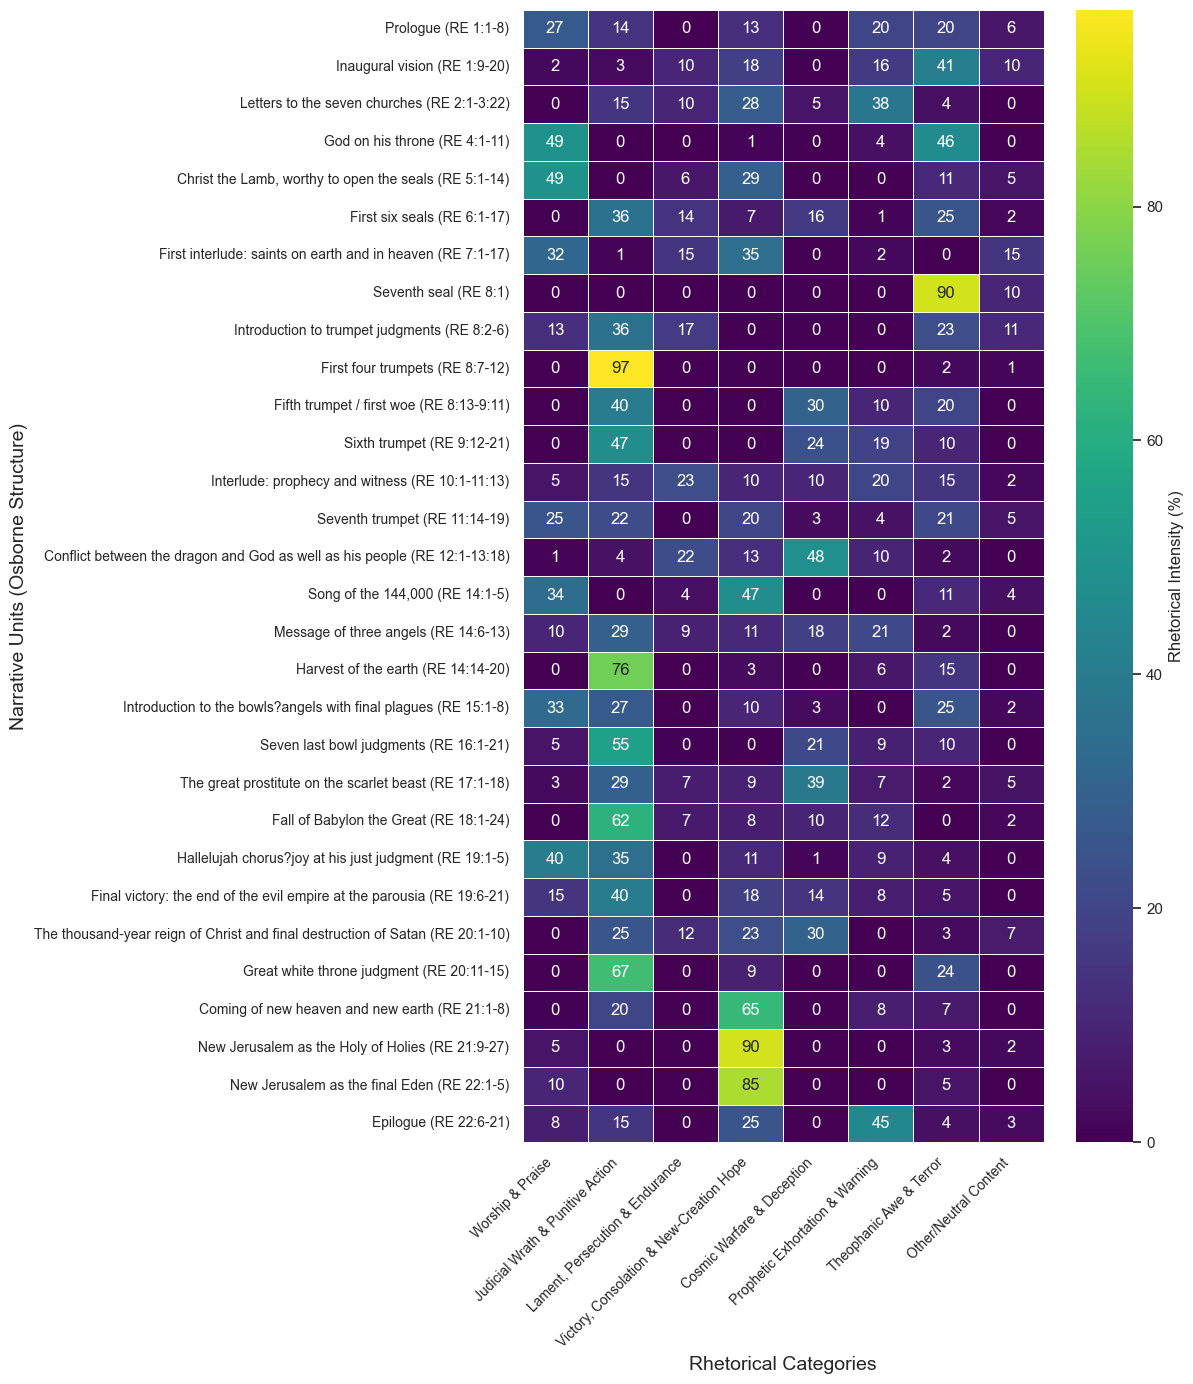

In [18]:
# @title Stage 4: Generate Macro-Architecture Heatmap (Figure 1)
# This cell visualizes the primary results from the LLM analysis, creating the
# heatmap of the rhetorical architecture of Revelation as referenced in the paper.

import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os
import sys
from pathlib import Path
import subprocess  # Added for font installation

# Ensure helper functions are available if the notebook is restarted
sys.path.append('../')
from src.config import *
from src.analysis_utils import load_json_file

# --- Configuration ---
PATH_BASE = "../"

RESULTS_JSON_FILE = os.path.join(PATH_RESULTS, f"{PROVIDER}_{STRUCTURE_NAME}_{BIBLE_NAME}.json") 
STRUCTURED_TEXT_FILE = os.path.join(PATH_PROCESSED, f"{STRUCTURE_NAME}_{BIBLE_NAME}_structured.json")

# Output file (as named in Appendix C.1)
OUTPUT_FIGURE_FILE = Path(PATH_FIGURES) / f"heatmap_{STRUCTURE_NAME}_{BIBLE_NAME}.jpg"

# Configure fonts globally - before any other matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'  # Sans-serif generally handles special chars better
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Calibri']
mpl.rcParams['axes.unicode_minus'] = False

# --- Font Installation and Configuration (Made safe for local execution) ---
try:
    # Only attempt to install fonts on Linux-based systems where apt-get is available
    if sys.platform.startswith('linux'):
        print("Attempting to install fonts on Linux...")
        # Check if running with root privileges, otherwise sudo might ask for a password
        if os.geteuid() == 0:
            subprocess.run(['apt-get', 'update'], check=True, capture_output=True)
            subprocess.run(['apt-get', 'install', '-y', 'fonts-dejavu'], check=True, capture_output=True)
        else:
            print("  > Running with sudo. This may ask for your password.")
            subprocess.run(['sudo', 'apt-get', 'update'], check=True, capture_output=True)
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'fonts-dejavu'], check=True, capture_output=True)
        print("✅ Fonts installed successfully.")
    else:
        print("ℹ️ Skipping automatic font installation on non-Linux system.")
except (subprocess.CalledProcessError, FileNotFoundError) as e:
    print(f"⚠️  Could not install or configure fonts: {e}")


def sanitize_text_data(df):
    """Remove or replace problematic characters in DataFrame labels"""
    # Function to replace the replacement character � with something safe
    def clean_text(text):
        if isinstance(text, str):
            return text.replace('\uFFFD', '?')  # Replace replacement char with ?
        return text
    
    # Clean row and column labels
    df.index = [clean_text(x) for x in df.index]
    df.columns = [clean_text(x) for x in df.columns]
    return df


def create_macro_heatmap(data_json_path, structured_text_path, config_categories, output_path):
    """
    Loads rhetorical vector data and generates a heatmap visualizing the
    rhetorical intensity of categories across all narrative units.
    """
    # Reset matplotlib settings to avoid interference
    plt.rcdefaults()
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Calibri']
    
    # --- Load Data ---
    data = load_json_file(data_json_path)
    structured_data = load_json_file(structured_text_path)

    if not data or not structured_data:
        print("❌ ERROR: Could not load necessary JSON files. Please ensure previous cells ran successfully.")
        return

    narrative_units = data.get('narrative_units', [])
    structured_units = structured_data.get('narrative_units', [])
    translation_name = data.get('translation', 'Unknown Translation')

    # --- THIS IS THE DYNAMIC PART ---
    structure_name = structured_data.get('structure_short', 'Unknown Structure')
    print(f"✅ Loaded data for '{translation_name}' using '{structure_name}' structure.")

    if not narrative_units:
        print("❌ ERROR: No narrative units found in the results data.")
        return

    # --- Prepare Data for Heatmap ---
    title_map = {unit['unit_id']: f"{unit['title']} ({unit['range']})" for unit in structured_units}
    sorted_units = sorted(narrative_units, key=lambda x: int(x.get('unit_id', 'unit_0').split('_')[-1]))

    heatmap_data = []
    row_labels = []

    for unit in sorted_units:
        unit_id = unit.get('unit_id')
        row_labels.append(title_map.get(unit_id, unit_id))

        vector = unit.get('final_rhetorical_vector', {})
        vector_values = [vector.get(cat, 0.0) for cat in config_categories]
        heatmap_data.append(vector_values)

    df_heatmap = pd.DataFrame(heatmap_data, index=row_labels, columns=config_categories)
    
    # Sanitize the dataframe to fix character issues
    df_heatmap = sanitize_text_data(df_heatmap)
    
    # Force seaborn to use our font settings
    sns.set(font='Arial', rc={'font.family': 'sans-serif'})
    
    # --- Create and Customize the Heatmap Plot ---
    fig, ax = plt.subplots(figsize=(12, 14))

    sns.heatmap(
        df_heatmap,
        annot=True,
        fmt=".0f",
        cmap="viridis",
        linewidths=.5,
        ax=ax,
        cbar_kws={'label': 'Rhetorical Intensity (%)'}
    )

    title_font = {'family': 'sans-serif', 'weight': 'bold', 'size': 18}
    label_font = {'family': 'sans-serif', 'size': 14}
    
    #ax.set_title(f'Figure 1: Macro-Architecture of Revelation ({translation_name})', fontdict=title_font, pad=20)
    ax.set_xlabel('Rhetorical Categories', fontdict=label_font)
    ax.set_ylabel(f'Narrative Units ({structure_name} Structure)', fontdict=label_font)

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # --- Save the Output ---
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Heatmap (Figure 1) successfully saved to '{output_path}'")
    print(f"Figure 1: Macro-Architecture of Revelation {translation_name}")
    plt.show()

# --- Execution ---
create_macro_heatmap(
    RESULTS_JSON_FILE,
    STRUCTURED_TEXT_FILE,
    ANALYTICAL_CONCEPTS_LIST,
    OUTPUT_FIGURE_FILE
)

In [ ]:
# @title Units with Highest Intensity per Rhetorical Category
import json
import pandas as pd
import os

# --- Configuration (should match previous cells) ---
sys.path.append('../')
from src.config import *
# Input file (generated by Stage 3)
RESULTS_JSON_FILE = os.path.join(PATH_RESULTS, f"{PROVIDER}_{STRUCTURE_NAME}_{BIBLE_NAME}.json")

def analyze_heatmap_data(data_json_path):
    """
    Analyzes the aggregated rhetorical vector data to identify key patterns.
    """
    data = None
    try:
        with open(data_json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"❌ ERROR: Results file not found at '{data_json_path}'. Please ensure Stage 3 ran successfully.")
        return
    except json.JSONDecodeError:
        print(f"❌ ERROR: Could not decode JSON from '{data_json_path}'. File might be corrupted.")
        return

    if not data or 'narrative_units' not in data:
        print("❌ ERROR: Invalid data structure in results file.")
        return

    narrative_units = data['narrative_units']
    if not narrative_units:
        print("❌ WARNING: No narrative units found in the results data.")
        return

    # Convert to DataFrame for easier analysis
    rows = []
    for unit in narrative_units:
        if unit.get('validation_passed') == 'True' and unit.get('final_rhetorical_vector'):
            row = {'unit_id': unit['unit_id'], 'verse_range': unit.get('verse_range', 'N/A')}
            row.update(unit['final_rhetorical_vector'])
            rows.append(row)

    if not rows:
        print("❌ WARNING: No units with valid and aggregated vectors found for analysis.")
        return

    df_analysis = pd.DataFrame(rows).set_index('unit_id')

    # --- 1. Darkest Cells (Highest Values) ---
    print("--- Units with Highest Intensity per Rhetorical Category ---")
    highest_values = {}
    for col in df_analysis.columns:
        if col in ['verse_range']: # Skip non-numeric columns
            continue
        max_value = df_analysis[col].max()
        if pd.isna(max_value):
            continue
        units_with_max = df_analysis[df_analysis[col] == max_value]
        highest_values[col] = {
            'max_percentage': max_value,
            'units': units_with_max.apply(lambda row: f"{row.name} ({row['verse_range']})", axis=1).tolist()
        }

    for category, info in highest_values.items():
        print(f"  - '{category}': {info['max_percentage']}% in {', '.join(info['units'])}")

    # --- 2. Notable Patterns in "Other/Neutral Content" ---
    print("\n--- Analysis of 'Other/Neutral Content' Distribution ---")
    if "Other/Neutral Content" in df_analysis.columns:
        other_neutral = df_analysis["Other/Neutral Content"]
        print(f"  - Average 'Other/Neutral Content' percentage: {other_neutral.mean():.2f}%")
        print(f"  - Standard Deviation: {other_neutral.std():.2f}")

        # Identify units with significantly high or low "Other/Neutral Content"
        high_threshold = other_neutral.mean() + other_neutral.std()
        low_threshold = other_neutral.mean() - other_neutral.std()

        units_high_neutral = other_neutral[other_neutral >= high_threshold].sort_values(ascending=False)
        units_low_neutral = other_neutral[other_neutral <= low_threshold].sort_values(ascending=True)

        if not units_high_neutral.empty:
            print("\n  - Units with notably HIGH 'Other/Neutral Content' (>= Mean + 1 Std Dev):")
            for unit_id, value in units_high_neutral.items():
                 print(f"    - {unit_id} ({df_analysis.loc[unit_id, 'verse_range']}): {value:.2f}%")
        else:
             print("\n  - No units with notably HIGH 'Other/Neutral Content'.")

        if not units_low_neutral.empty:
            print("\n  - Units with notably LOW 'Other/Neutral Content' (<= Mean - 1 Std Dev):")
            for unit_id, value in units_low_neutral.items():
                 print(f"    - {unit_id} ({df_analysis.loc[unit_id, 'verse_range']}): {value:.2f}%")
        else:
             print("\n  - No units with notably LOW 'Other/Neutral Content'.")


        # Provide some context for high/low units
        print("\n  - Interpretation Notes:")
        print("    - High 'Other/Neutral Content' often indicates narrative transitions, descriptive passages, or sections where multiple rhetorical modes are highly interwoven and difficult to disentangle.")
        print("    - Low 'Other/Neutral Content' often indicates passages strongly dominated by one or a few specific rhetorical categories.")

    else:
        print("  - 'Other/Neutral Content' column not found in the data.")


# --- Execution ---
analyze_heatmap_data(RESULTS_JSON_FILE)